# Planetary Variables
## Land Surface Temperature
### Extreme Temperatures over Bordeaux - France

This Jupyter Notebook demonstrates how to quantify heatwave over cities based on the [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) product using Sentinel Hub's [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/). This Notebook returns a timeserie from Sentinel Hub's API.

In this example, we retrieve the Temperature anomalies based on Planetary variable Land Surface Temperature at 1km resolution since 2013 over Bordeaux, France. 

The anomaly of a variable is the variation relative to the climatological normal. The normal is the long-term average of the same variable and is used as a baseline value. The normal is typically computed by calculating a climatology over a long period (the climate normal period). A positive anomaly indicates that the observed temperature was warmer than the baseline, while a negative anomaly indicates that the observed temperature was cooler than the baseline.

In [34]:
import json
import pandas as pd

import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from sentinelhub import (
    SHConfig,
    geometry,
    CRS,
    SentinelHubStatistical,
    DataCollection,
    SentinelHubDownloadClient,
)

## Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook.

Currently, the following cell is set up in a way that you need to specify your `client_id` & `client_secret` when running it.


In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

## Set collection IDS

The [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) layers are available as subscriptions through Sentinel Hub's [TPDI](https://docs.sentinel-hub.com/api/latest/api/data-import/) service. Once the area of interest and variables are subscribed to, the data are then automatically imported into Sentinel Hub and available by specifying the Collection ID. 

In this example, we will use the collection IDs available from [Planet's Sandbox Data page for Land Surface Temperature](https://collections.sentinel-hub.com/land-surface-temperature/sandbox-data.html). 

A collection ID will allow you to retrieve the data from the collection, just as you would with a standard dataset (e.g. Sentinel-2). For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).


In [3]:
collection_id = "6b613b07-410a-4312-93ad-d1751fdc55de"

## Area of Interest

First, we define an area of interest, located for Bordeaux, city center, in France.

You can also explore the area of interest in Sentinel Hub's [EO Browser](https://sentinelshare.page.link/XN9P).

In [36]:
# Read a geojson containing a polygon representing a parcel of interest
parcel_data = json.loads(open("bordeaux.geojson").read())
parcel_polygon = Polygon(parcel_data["features"][0]["geometry"]["coordinates"][0][0])

# Convert to a Sentinel Hub geometry
parcel_geo = geometry.Geometry(parcel_polygon, crs=CRS(4326))

del parcel_data

## Compute Land Surface Temperature Anomaly

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubRequest` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). 

### Set the evalscript

Land Surface Temperature is available twice a day (at 1.30 and 13.30 solar local time), in this example we select the 13.30 sensing time (`sensing_time="1330"`).

In [37]:
time_series_evalscript = """
//VERSION=3
sensing_time="1330"
function setup() {
    return {
        input: [{bands: ["LST", "dataMask"]}],
        output: [
            { id: "LST", bands: 1, sampleType: "FLOAT32" },
            { id: "dataMask", bands: 1, sampleType: "UINT8" }
        ],
        mosaicking: "TILE"
    };
}
// Filter out scenes where the sensing time matches specified sensing time
function preProcessScenes (collections) {
    collections.scenes.tiles = collections.scenes.tiles.filter(function (tile) {
        return tile.dataPath.includes("T"+sensing_time);
    })
    collections.scenes.tiles.sort((a, b) => new Date(b.date) - new Date(a.date));
    return collections
}
function evaluatePixel(samples) {
    var sample = samples[0].LST
    var nodata = samples[0].dataMask

    return {
        LST: [sample/100],
        dataMask: [nodata]
    };
}
"""

### Get the data

We will extract the data from January 1st 2014 to December 31st 2022 at the native resolution (0.01 degree -> ±1km). The LST will be aggregated over the geometry (`parcel_geo` -> city of Bordeaux) for each day (`P1D`)

In [38]:
# Provide credentials to connect to Sentinel Hub
# https://sentinelhub-py.readthedocs.io/en/latest/configure.html#environment-variables
config = SHConfig.load()
data_collection = DataCollection.define_byoc(collection_id)
input_data = SentinelHubStatistical.input_data(data_collection)

# Specifiy your time of interest (TOI)
time_of_interest = "2014-01-01", "2022-12-31"

# Specify a resolution
resx = 0.01
resy = 0.01


# Create the requests
aggregation = SentinelHubStatistical.aggregation(
    evalscript=time_series_evalscript, time_interval=time_of_interest, aggregation_interval="P1D", resolution=(resx, resy)
)

request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=parcel_geo,
        config=config,
    )

# Post the requests
download_requests = [request.download_list[0]]
client = SentinelHubDownloadClient(config=config)
stats_response = client.download(download_requests)

### Extract the time series
From the request, we will now retrieve the timeserie as a DataFrame

In [39]:
series = pd.json_normalize(stats_response[0]["data"])
series['date'] = pd.to_datetime(series['interval.from'])
series.set_index('date', inplace=True)

### Temporal Analysis

To extract the anomaly, we will calculate: 
- 20 days rolling backward windows average: The rolling average, sometimes referred to as a moving average, is a metric that calculates trends over short periods of time. By considering the short trend in the Anomaly calculation, the results will focus on the persistent extreme temperatures. 
- climatology: Climatologies can be computed based on different terms. For this example, we will compute climatological averages, which are the mean for each day of the year over the specified period of time (2014-2022).
- Anomaly: The difference between the baseline (climatology) and the observations (20 days averaged in this example)

In [40]:
backward_average_window_size = 20
column = "outputs.LST.bands.B0.stats.mean"

# Fill missing dates
df = pd.DataFrame({"observation": series[column]})
continuous_dates = pd.date_range(start=df.index.min(), end=df.index.max())
df = df.reindex(continuous_dates)

#calculate the backward average
df["average"] = df["observation"].rolling(
    window=pd.Timedelta(days=backward_average_window_size), min_periods=1, center=False, closed=None
    ).mean()[backward_average_window_size - 1:]

# Calculate the climatology
df["doy"] = df.index.dayofyear
ser_per_doy = df.groupby("doy")["average"].agg("mean")
ser_per_doy.name = "climatology"
df = df.join(ser_per_doy, on="doy").drop(columns=["doy"])

#calculate the anomaly
df["anomaly"] = df["average"] - df["climatology"]

### Plot results

In the next cell, we will plot the timeserie with the raw observations and the 20 days rolling windows average

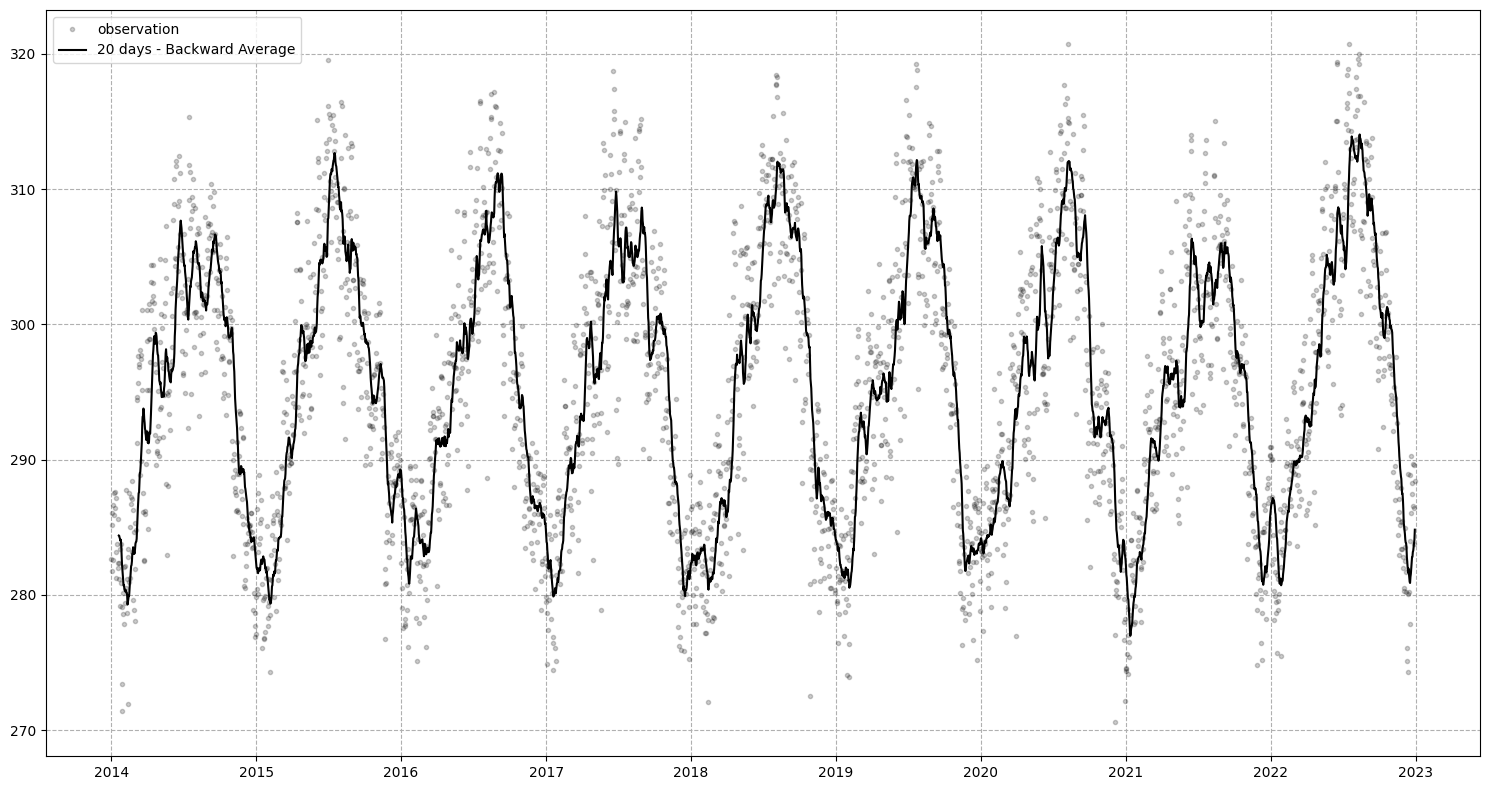

In [41]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.plot(df["observation"], ".", color="black", alpha=0.2, label="observation")
ax.plot(df["average"], color="black", label=f"{backward_average_window_size} days - Backward Average")
ax.get_figure().tight_layout()
ax.grid(linestyle="--")
ax.legend()

### Plot Anomaly

Finally, we will plot the anonaly on top of the timeserie from the 20 days rolling windows average. We will color the positive anomaly (warmer than normal condition) in red and the negetive anomaly (cooler than normal condition) in blue.

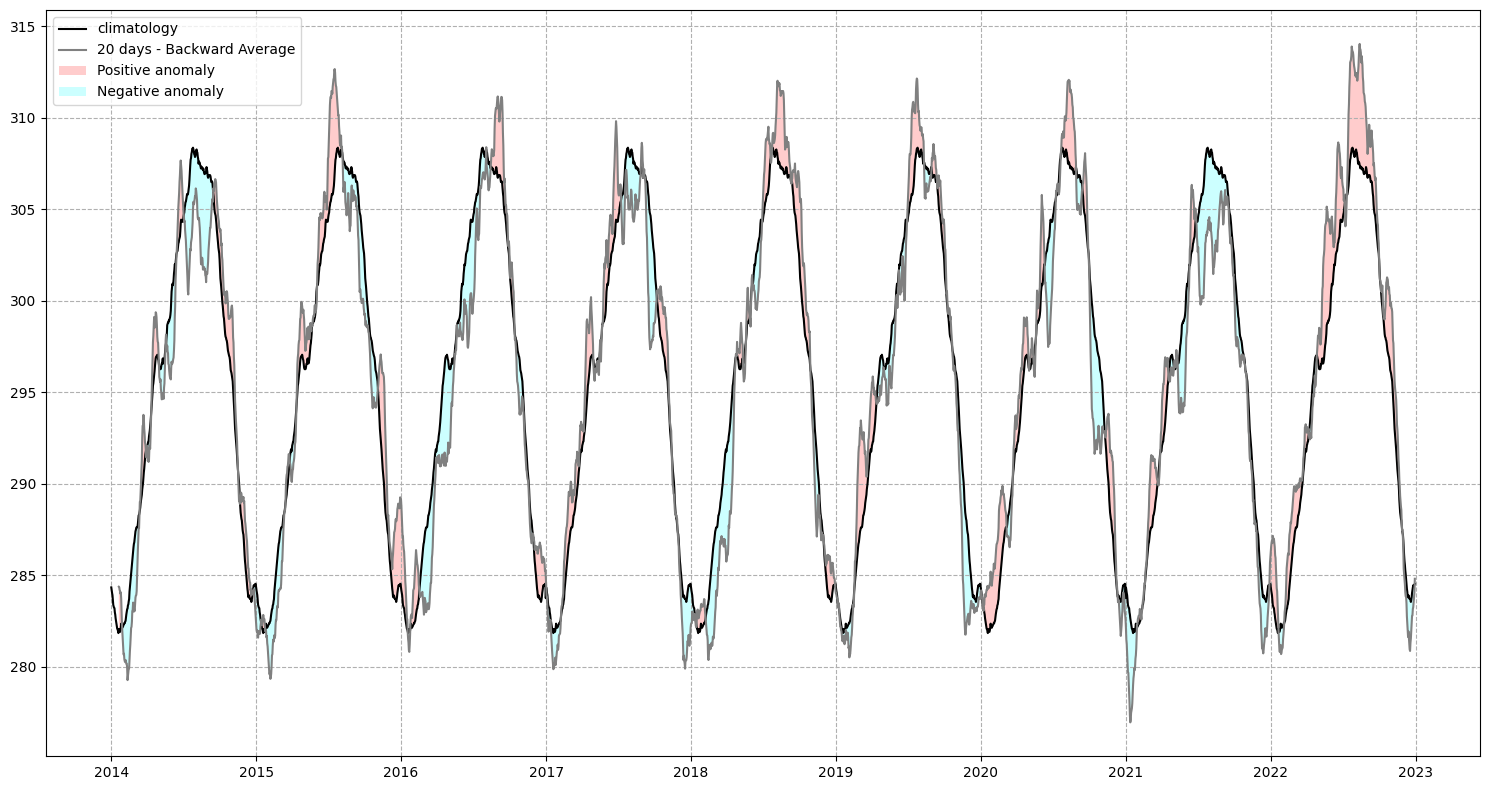

In [42]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.plot(df["climatology"], label=f"climatology", color="black")
ax.plot(df["average"], color="grey", label=f"{backward_average_window_size} days - Backward Average")

ax.fill_between(df.index.values, df["average"], df["climatology"], where=df["average"] >= df["climatology"],
            facecolor="red", alpha=0.2, interpolate=False, label="Positive anomaly")
ax.fill_between(df.index.values, df["average"], df["climatology"], where=df["climatology"] >= df["average"],
            facecolor="cyan", alpha=0.2, interpolate=False, label="Negative anomaly")

ax.get_figure().tight_layout()
ax.grid(linestyle="--")
ax.legend()